### Task 3

In [9]:
import pandas as pd
import logging
import os
import sys
import mlflow
import pickle
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../scripts'))

from forecasting.forecast_analysis import load_model, forecast_and_visualize

In [10]:
 datasets = {
        "TSLA": "../data/processed/TSLA_processed.csv",
        "SPY": "../data/processed/SPY_processed.csv",
        "BND": "../data/processed/BND_processed.csv"
    }

In [11]:
steps = 252  # Forecast 1 year

2024-11-19 16:14:08,734 - Loaded ARIMA model for TSLA from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\arima_tsla\model.pkl.


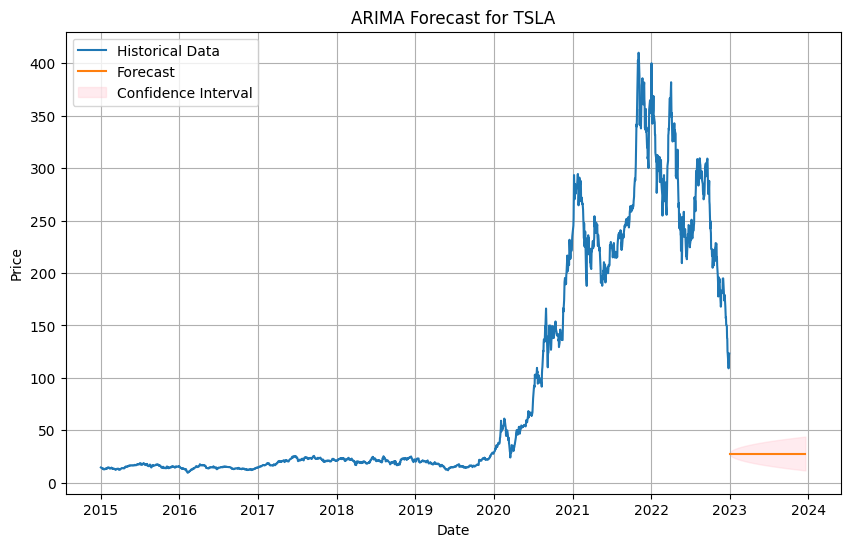

2024-11-19 16:14:09,141 - ARIMA forecast for TSLA completed and visualized.
2024-11-19 16:14:16,030 - Loaded SARIMA model for TSLA from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_tsla\model.pkl.


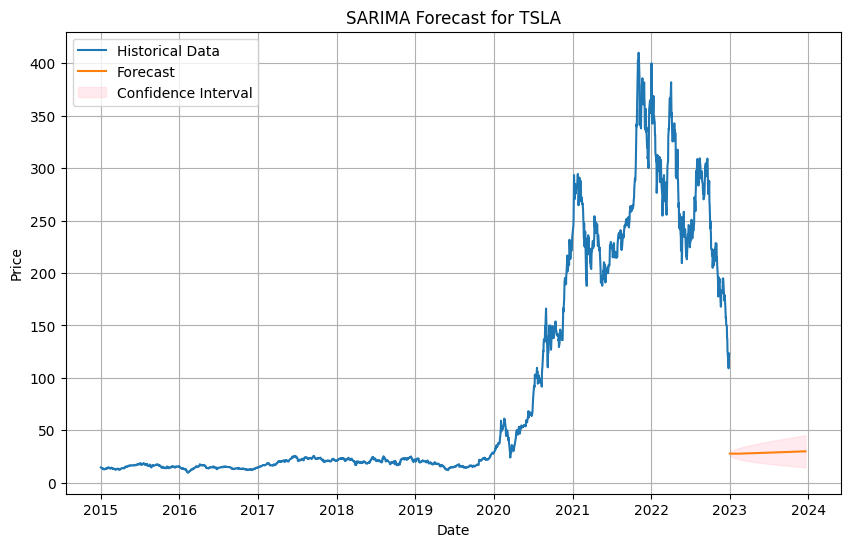

2024-11-19 16:14:18,152 - SARIMA forecast for TSLA completed and visualized.
2024-11-19 16:14:20,858 - Loaded ARIMA model for SPY from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\arima_spy\model.pkl.


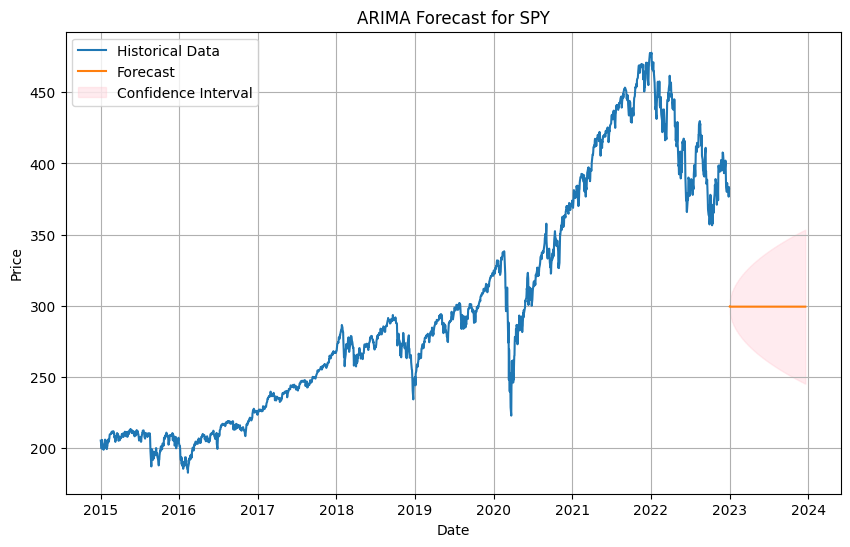

2024-11-19 16:14:21,278 - ARIMA forecast for SPY completed and visualized.
2024-11-19 16:14:27,118 - Loaded SARIMA model for SPY from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_spy\model.pkl.


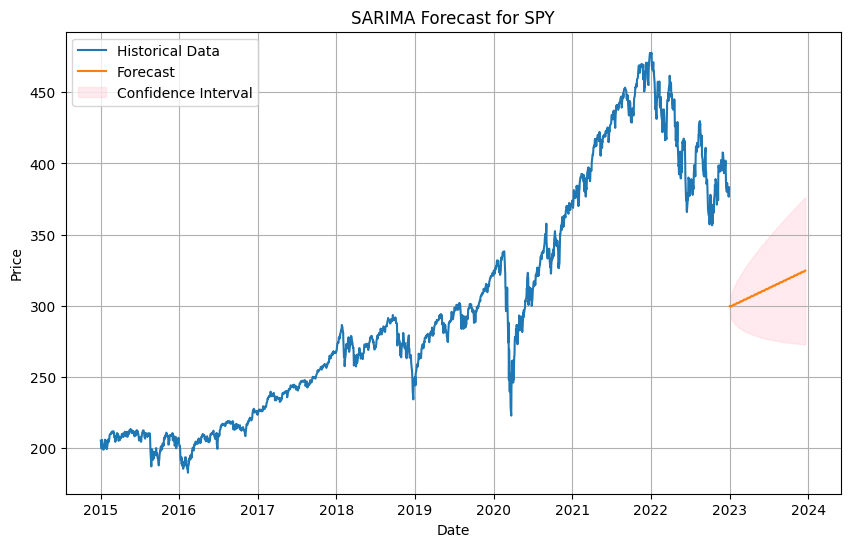

2024-11-19 16:14:32,082 - SARIMA forecast for SPY completed and visualized.
2024-11-19 16:14:32,510 - Loaded ARIMA model for BND from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\arima_bnd\model.pkl.


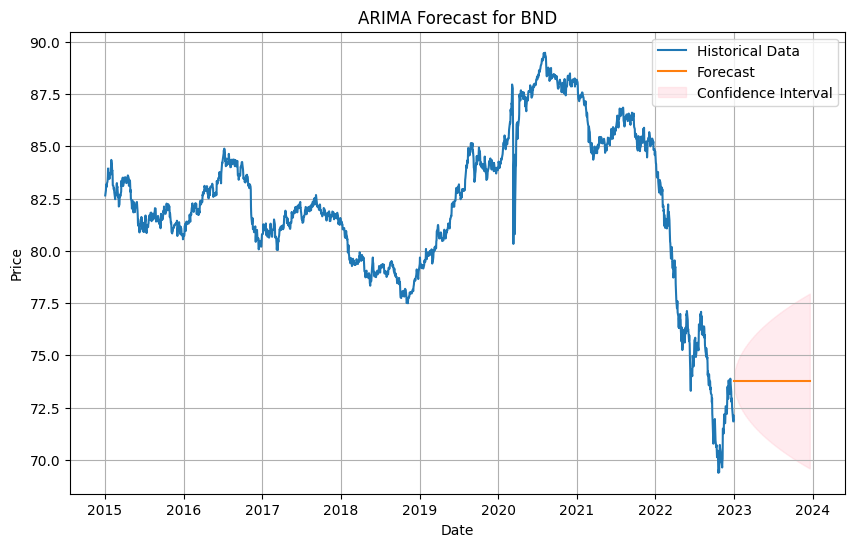

2024-11-19 16:14:32,986 - ARIMA forecast for BND completed and visualized.
2024-11-19 16:14:33,830 - Loaded SARIMA model for BND from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_bnd\model.pkl.


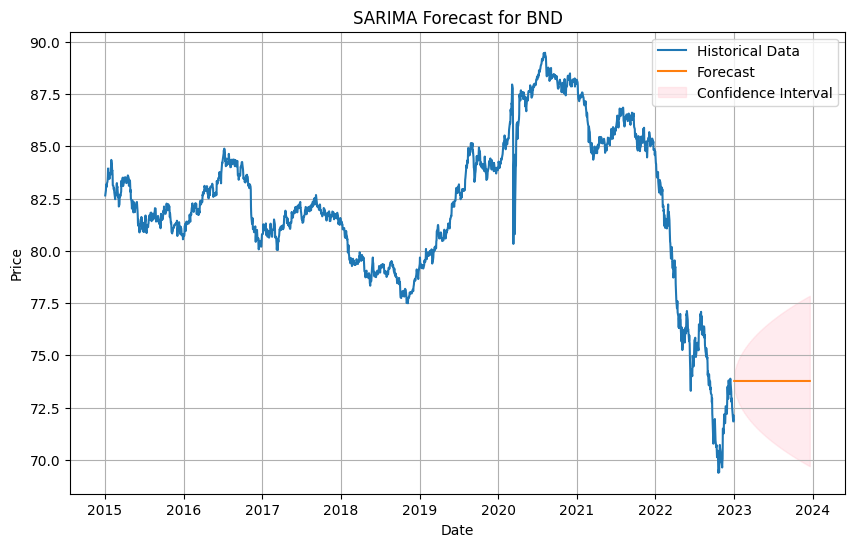

2024-11-19 16:14:34,269 - SARIMA forecast for BND completed and visualized.


In [12]:
import warnings
warnings.filterwarnings("ignore")

for dataset_name, file_path in datasets.items():
    data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
    close_data = data["Close"]

    # Load ARIMA Model
    arima_model = load_model("ARIMA", dataset_name)
    forecast_and_visualize(arima_model, close_data, steps, dataset_name, "ARIMA")

    # Load SARIMA Model
    sarima_model = load_model("SARIMA", dataset_name)
    sarima_forecast = sarima_model.forecast(steps=steps)
    forecast_and_visualize(sarima_model, close_data, steps, dataset_name, "SARIMA")

### Task 4

In [16]:
forecast_data = {}

In [17]:
for dataset_name, file_path in datasets.items():
    data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
    close_data = data["Close"]

    sarima_model = load_model("SARIMA", dataset_name)
    sarima_forecast = sarima_model.forecast(steps=steps)
    forecast_data[dataset_name] = sarima_forecast 

2024-11-19 16:40:34,085 - Loaded SARIMA model for TSLA from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_tsla\model.pkl.
2024-11-19 16:40:38,718 - Loaded SARIMA model for SPY from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_spy\model.pkl.
2024-11-19 16:40:40,131 - Loaded SARIMA model for BND from C:\Users\USER\Documents\OPLearning\10_Academy\Week_11\models\sarima_bnd\model.pkl.
